In [1]:
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
import opendatasets as od
from pathlib import Path
from collections import Counter
import splitfolders
from sklearn.metrics import precision_score,recall_score

In [2]:
source_path = "/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
data_dir = Path('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/')

train_dir = data_dir / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

datasets="https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone"

In [3]:
od.download(datasets)
splitfolders.ratio("data", output="dataset",seed=831, ratio=(.8, 0.1,0.1)) 

Skipping, found downloaded files in ".\ct-kidney-dataset-normal-cyst-tumor-and-stone" (use force=True to force download)


Copying files: 12446 files [00:18, 670.41 files/s]


In [2]:
trans=transforms.Compose([transforms.Resize((224,224)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                         
                         ])

In [3]:
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [4]:

classifier = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
classifier.fc=nn.Linear(2048,4)

Text(0.5, 1.0, '              Normal,                Normal,                  Cyst,                  Cyst,                Normal,                Normal,                 Tumor,                Normal,                  Cyst,                Normal,                 Stone,                Normal,                 Tumor,                Normal,                Normal,                 Stone,                Normal,                Normal,                Normal,                Normal,                Normal,                 Tumor,                Normal,                Normal,                Normal,                 Tumor,                 Tumor,                Normal,                 Stone,                 Tumor,                Normal,                 Tumor, ')

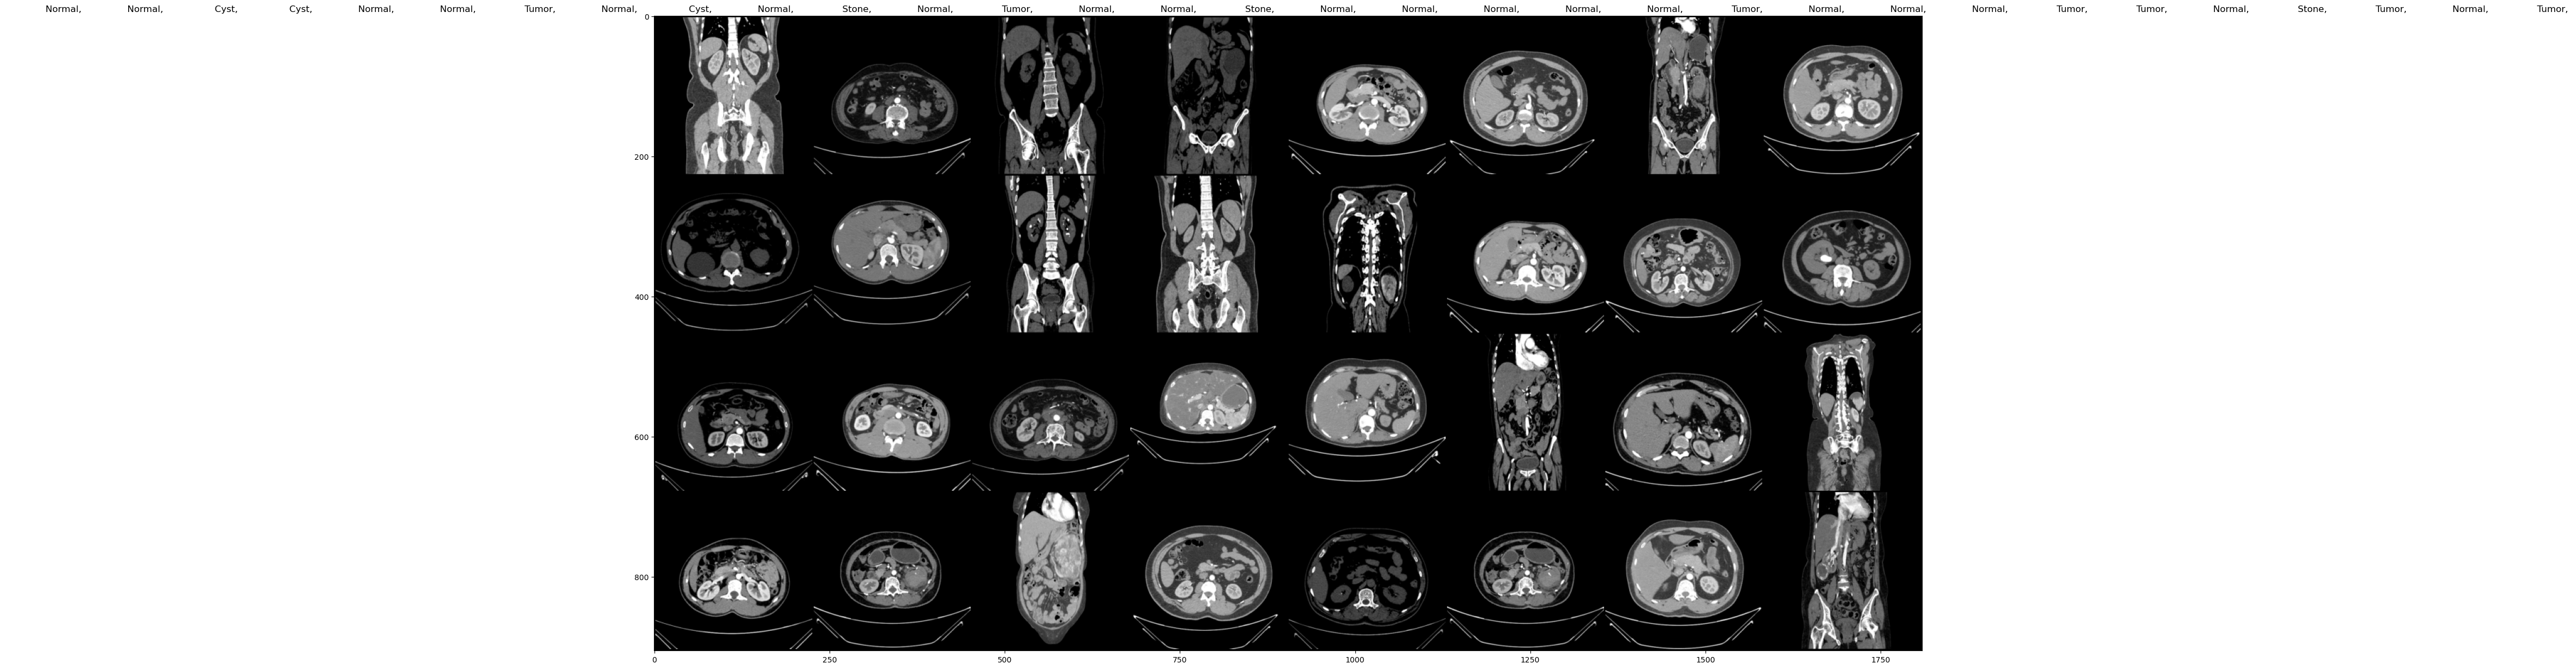

In [5]:
classes=(train_dataset.classes)
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
fig = plt.figure(figsize=(30, 30))

images,labels=next(iter(train_loader))
img = images / 2 + 0.5 
grid_img = torchvision.utils.make_grid(img)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

plt.title(' '.join('%20s, ' % classes[labels[j]] for j in range(len(labels))))


In [6]:
import pandas as pd
data=pd.read_csv('kidneyData.csv')

print(data.shape)
data

(12446, 6)


,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [7]:
category=np.unique(data['Class'])
category
id,count=np.unique(data['Class'],return_counts=True)
id,count

(array(['Cyst', 'Normal', 'Stone', 'Tumor'], dtype=object),
 array([3709, 5077, 1377, 2283], dtype=int64))

In [8]:
median=np.median(count)
class_weight=[]
for i in range(len(category)):
    print(f'{category[i]} : {median/count[i]}')
    class_weight.append(median/count[i])
class_weight=torch.FloatTensor(class_weight)

Cyst : 0.8077648961984363
Normal : 0.5901122710261966
Stone : 2.175744371822803
Tumor : 1.3123083661848445


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda')

In [29]:
run = wandb.init(project="kidney_classification", entity="k9789544219")
epochs=1
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans) 
test_loader=DataLoader(test_dataset,shuffle=False)
optimizer=torch.optim.Adam(classifier.parameters(),lr=10**-5)
classifier=classifier.to(device)
class_weight=class_weight.to(device)
for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        pred_labels=np.array([])
        true_labels=np.array([])
        train_total_accuracy=0.0
        train_total=0
        for batch_size,(image,labels) in tqdm(enumerate(test_loader)):
           
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            predicted=torch.argmax(output,dim=-1)
            
            true_labels=np.append(true_labels,labels.cpu().numpy())
            pred_labels=np.append(pred_labels,predicted.cpu().numpy())
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total+=len(labels)
           
            train_total_accuracy+=(predicted == labels).sum().item() 
            
print(true_labels)
wandb.sklearn.plot_confusion_matrix(true_labels,pred_labels,'Cyst', 'Normal', 'Stone', 'Tumor'])})
wandb.log({'pr': wandb.plots.precision_recall(y_test, y_probas, nb.classes_)})
            
        

  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.62it/s]
2it [00:00,  2.45it/s]
3it [00:01,  2.95it/s]
4it [00:01,  3.22it/s]
5it [00:01,  3.28it/s]
6it [00:01,  3.48it/s]
7it [00:02,  3.52it/s]
8it [00:02,  3.37it/s]
9it [00:02,  3.29it/s]
10it [00:03,  3.45it/s]
11it [00:03,  3.48it/s]
12it [00:03,  3.55it/s]
13it [00:03,  3.55it/s]
14it [00:04,  3.59it/s]
15it [00:04,  3.56it/s]
16it [00:04,  3.57it/s]
17it [00:05,  3.69it/s]
18it [00:05,  3.62it/s]
19it [00:05,  3.36it/s]
20it [00:05,  3.41it/s]
21it [00:06,  3.62it/s]
22it [00:06,  3.66it/s]
23it [00:06,  3.70it/s]
24it [00:07,  3.47it/s]
25it [00:07,  3.53it/s]
26it [00:07,  3.62it/s]
27it [00:07,  3.39it/s]
28it [00:08,  3.52it/s]
29it [00:08,  3.52it/s]
30it [00:08,  3.53it/s]
31it [00:09,  3.53it/s]
32it [00:09,  3.59it/s]
33it [00:09,  3.62it/s]
34it [00:09,  3.66it/s]
35it [00:10,  3.76it/s]
36it [00:10,  3.59it/s]
37it [00:10,  3.44it/s]
38it [00:11,  3.44it/s]
40it [00:11,  3.54it/s]
100%|██████████|

[0. 0. 0. ... 3. 3. 3.]


In [11]:

def train_eval(run,optimizer,device,classifier,epochs,class_weight,train_loader,valid_loader,test_loader):
   
    wandb.watch(classifier, log='all')
    classifier.train()
    classifier=classifier.to(device)
    class_weight=class_weight.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        
        train_total_accuracy=0.0
        train_total=0
        for batch_size,(image,labels) in tqdm(enumerate(train_loader)):
           
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            predicted=torch.argmax(output,dim=-1)
            
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total+=len(labels)
           
            train_total_accuracy+=(predicted == labels).sum().item() 
            
        
        wandb.log({
        'average_train_loss': train_total_loss/num_batch,
        'average_train_accuracy' :train_total_accuracy/train_total    
            })
        classifier.eval()
        val_total_loss=0.0
        val_total_accuracy=0.0
        val_total_precision_considering_class=0.0
        val_total_recall_considering_class=0.0
        val_total=0
        num_batch=0
        
        with torch.no_grad():
            for image,labels in tqdm(valid_loader):
                
                image=image.to(device)
                labels=labels.to(device)
                output=classifier(image)
                loss=F.cross_entropy(output,labels,weight=class_weight)
                
                _,predicted=torch.max(output,1)
                num_batch+=1
                val_total_loss+=loss.item()
                val_total_accuracy+=(predicted == labels).sum().item() 
                val_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
                val_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
               
                val_total+=len(labels)
           
            
           
            
            wandb.log({
            'average_val_loss': val_total_loss/num_batch,
            'average_val_accuracy' :val_total_accuracy/val_total,    
            'average_val_precsion' :val_total_precision_considering_class/num_batch,    
            'average_val_recall' :val_total_recall_considering_class/num_batch
       
        })
    with torch.no_grad():
        classifier.eval()
        test_total_loss=0.0
        test_total_accuracy=0.0
        test_total_precision_considering_class=0.0
        test_total_recall_considering_class=0.0
        test_total=0
        num_batch=0        
        for image,labels in tqdm(test_loader):
            
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            loss=F.cross_entropy(output,labels,weight=class_weight)
            
            _,predicted=torch.max(output,1)
            num_batch+=1
            test_total_loss+=loss.item()
            test_total_accuracy+=(predicted == labels).sum().item() 
            test_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
            test_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
           
            test_total+=len(labels)
                
    print(f'average_test_loss: {test_total_loss/num_batch}\naverage_test_accuracy :{test_total_accuracy/test_total}\naverage_test_precsion :{test_total_precision_considering_class/num_batch}\naverage_test_recall :{test_total_recall_considering_class/num_batch}')
    torch.save(classifier.state_dict(),'kidney_model.pt')
    artifact=wandb.Artifact('model',type='model')
    artifact.add_file('kidney_model.pt')
    run.log_artifact(artifact)  
    



In [12]:

sweep_config={
'name' : 'parameter_tuning',
'method': 'grid',
'metric': {'name': 'val_loss','goal' :'minimize'},
'parameters':{
    'learning_rate' :
     {'values': [10**-5,10**-3]},
    'epochs': 
    {'values':[1,5,10]}
    
    },
'early_terminate':{
'type': 'hyperband',
'min_iter': 3
}
}




In [13]:
def run_sweep(config=None):
    
    
    run=wandb.init(config=config)
    wandb_config=wandb.config
    loss=nn.CrossEntropyLoss(weight=class_weight)
    train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
    valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
    test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
    train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
    valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
    test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
    optimizer=torch.optim.Adam(classifier.parameters(),lr=wandb_config.learning_rate)
    train_eval(run,optimizer,device,classifier,wandb_config.epochs,class_weight,train_loader,valid_loader,test_loader)


In [14]:
sweep_id=wandb.sweep(sweep_config,project='kidney_classification')
wandb.agent(sweep_id,run_sweep)
wandb.finish()

Create sweep with ID: hpgfuhbo
Sweep URL: https://wandb.ai/k9789544219/kidney_classification/sweeps/hpgfuhbo


wandb: Agent Starting Run: nvllr62c with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 1e-05
wandb: Currently logged in as: k9789544219. Use `wandb login --relogin` to force relogin


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:06,  6.11s/it]
2it [00:06,  2.78s/it]
3it [00:06,  1.69s/it]
4it [00:07,  1.17s/it]
5it [00:07,  1.11it/s]
6it [00:08,  1.38it/s]
7it [00:08,  1.69it/s]
8it [00:08,  2.01it/s]
9it [00:09,  2.31it/s]
10it [00:09,  2.47it/s]
11it [00:09,  2.74it/s]
12it [00:09,  2.90it/s]
13it [00:10,  3.04it/s]
14it [00:10,  3.13it/s]
15it [00:10,  3.24it/s]
16it [00:11,  3.32it/s]
17it [00:11,  3.15it/s]
18it [00:11,  3.10it/s]
19it [00:12,  3.12it/s]
20it [00:12,  3.09it/s]
21it [00:12,  3.01it/s]
22it [00:13,  2.90it/s]
23it [00:13,  2.81it/s]
24it [00:13,  2.66it/s]
25it [00:14,  2.67it/s]
26it [00:14,  2.88it/s]
27it [00:14,  3.00it/s]
28it [00:15,  3.18it/s]
29it [00:15,  3.33it/s]
30it [00:15,  3.31it/s]
31it [00:16,  3.37it/s]
32it [00:16,  3.25it/s]
33it [00:16,  3.34it/s]
34it [00:16,  3.39it/s]
35it [00:17,  3.46it/s]
36it [00:17,  3.50it/s]
37it [00:17,  3.32it/s]
38it [00:18,  3.11it/s]
39it [00:18,  2.97it/s]
40it [00:18,  3.

average_test_loss: 0.34453729800879956
average_test_accuracy :0.9719775820656525
average_test_precsion :1.0
average_test_recall :0.97265625


average_train_accuracy,▁
average_train_loss,▁
average_val_accuracy,▁
average_val_loss,▁
average_val_precsion,▁
average_val_recall,▁
average_train_accuracy,0.76966
average_train_loss,0.9124
average_val_accuracy,0.96457
average_val_loss,0.36965
average_val_precsion,0.99926


wandb: Agent Starting Run: u227t7uq with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.001


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.83it/s]
2it [00:00,  2.64it/s]
3it [00:01,  3.06it/s]
4it [00:01,  3.28it/s]
5it [00:01,  3.37it/s]
6it [00:01,  3.51it/s]
7it [00:02,  3.55it/s]
8it [00:02,  3.56it/s]
9it [00:02,  3.59it/s]
10it [00:02,  3.57it/s]
11it [00:03,  3.55it/s]
12it [00:03,  3.52it/s]
13it [00:03,  3.50it/s]
14it [00:04,  3.50it/s]
15it [00:04,  3.53it/s]
16it [00:04,  3.49it/s]
17it [00:04,  3.58it/s]
18it [00:05,  3.58it/s]
19it [00:05,  3.50it/s]
20it [00:05,  3.59it/s]
21it [00:06,  3.61it/s]
22it [00:06,  3.62it/s]
23it [00:06,  3.65it/s]
24it [00:06,  3.71it/s]
25it [00:07,  3.60it/s]
26it [00:07,  3.56it/s]
27it [00:07,  3.62it/s]
28it [00:08,  3.61it/s]
29it [00:08,  3.63it/s]
30it [00:08,  3.61it/s]
31it [00:08,  3.62it/s]
32it [00:09,  3.55it/s]
33it [00:09,  3.55it/s]
34it [00:09,  3.54it/s]
35it [00:09,  3.58it/s]
36it [00:10,  3.47it/s]
37it [00:10,  3.39it/s]
38it [00:10,  3.41it/s]
39it [00:11,  3.32it/s]
40it [00:11,  3.

average_test_loss: 0.21506547665339895
average_test_accuracy :0.9247397918334668
average_test_precsion :1.0
average_test_recall :0.9265625


average_train_accuracy,▁
average_train_loss,▁
average_val_accuracy,▁
average_val_loss,▁
average_val_precsion,▁
average_val_recall,▁
average_train_accuracy,0.94294
average_train_loss,0.18604
average_val_accuracy,0.92995
average_val_loss,0.21574
average_val_precsion,1.0


wandb: Agent Starting Run: 6dqr4dur with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.77it/s]
2it [00:00,  2.49it/s]
3it [00:01,  2.95it/s]
4it [00:01,  3.25it/s]
5it [00:01,  3.29it/s]
6it [00:01,  3.42it/s]
7it [00:02,  3.46it/s]
8it [00:02,  3.51it/s]
9it [00:02,  3.51it/s]
10it [00:03,  3.49it/s]
11it [00:03,  3.62it/s]
12it [00:03,  3.64it/s]
13it [00:03,  3.63it/s]
14it [00:04,  3.66it/s]
15it [00:04,  3.64it/s]
16it [00:04,  3.69it/s]
17it [00:04,  3.70it/s]
18it [00:05,  3.70it/s]
19it [00:05,  3.54it/s]
20it [00:05,  3.60it/s]
21it [00:06,  3.55it/s]
22it [00:06,  3.61it/s]
23it [00:06,  3.67it/s]
24it [00:06,  3.66it/s]
25it [00:07,  3.65it/s]
26it [00:07,  3.63it/s]
27it [00:07,  3.68it/s]
28it [00:07,  3.66it/s]
29it [00:08,  3.60it/s]
30it [00:08,  3.41it/s]
31it [00:08,  3.49it/s]
32it [00:09,  3.54it/s]
33it [00:09,  3.50it/s]
34it [00:09,  3.51it/s]
35it [00:09,  3.59it/s]
36it [00:10,  3.64it/s]
37it [00:10,  3.68it/s]
38it [00:10,  3.58it/s]
39it [00:11,  3.60it/s]
40it [00:11,  3.

average_test_loss: 0.00037992596069615916
average_test_accuracy :1.0
average_test_precsion :1.0
average_test_recall :1.0


average_train_accuracy,▁████
average_train_loss,█▁▁▁▁
average_val_accuracy,▁▁█▅█
average_val_loss,█▃▂▂▁
average_val_precsion,▁▁▁▁▁
average_val_recall,▁▁█▄█
average_train_accuracy,1.0
average_train_loss,0.00017
average_val_accuracy,1.0
average_val_loss,0.00086
average_val_precsion,1.0


wandb: Agent Starting Run: mzr4knvq with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.77it/s]
2it [00:00,  2.59it/s]
3it [00:01,  2.94it/s]
4it [00:01,  3.20it/s]
5it [00:01,  3.45it/s]
6it [00:01,  3.54it/s]
7it [00:02,  3.58it/s]
8it [00:02,  3.61it/s]
9it [00:02,  3.56it/s]
10it [00:03,  3.58it/s]
11it [00:03,  3.48it/s]
12it [00:03,  3.53it/s]
13it [00:03,  3.56it/s]
14it [00:04,  3.56it/s]
15it [00:04,  3.71it/s]
16it [00:04,  3.69it/s]
17it [00:04,  3.74it/s]
18it [00:05,  3.81it/s]
19it [00:05,  3.82it/s]
20it [00:05,  3.74it/s]
21it [00:05,  3.77it/s]
22it [00:06,  3.74it/s]
23it [00:06,  3.74it/s]
24it [00:06,  3.74it/s]
25it [00:07,  3.65it/s]
26it [00:07,  3.74it/s]
27it [00:07,  3.70it/s]
28it [00:07,  3.74it/s]
29it [00:08,  3.76it/s]
30it [00:08,  3.74it/s]
31it [00:08,  3.72it/s]
32it [00:08,  3.73it/s]
33it [00:09,  3.79it/s]
34it [00:09,  3.86it/s]
35it [00:09,  3.82it/s]
36it [00:09,  3.69it/s]
37it [00:10,  3.60it/s]
38it [00:10,  3.60it/s]
39it [00:10,  3.58it/s]
40it [00:11,  3.

average_test_loss: 1.3793082624673842
average_test_accuracy :0.2978382706164932
average_test_precsion :0.994140625
average_test_recall :0.290625


average_train_accuracy,█▁▁▂▁
average_train_loss,▁█▆▆▆
average_val_accuracy,█▁▂▁▁
average_val_loss,▁████
average_val_precsion,█▄▁▄▄
average_val_recall,█▁▂▁▁
average_train_accuracy,0.35399
average_train_loss,1.38622
average_val_accuracy,0.29791
average_val_loss,1.37917
average_val_precsion,0.99369


wandb: Agent Starting Run: uei9dvvu with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.59it/s]
2it [00:00,  2.38it/s]
3it [00:01,  2.77it/s]
4it [00:01,  2.98it/s]
5it [00:01,  3.14it/s]
6it [00:02,  3.31it/s]
7it [00:02,  3.36it/s]
8it [00:02,  3.35it/s]
9it [00:02,  3.33it/s]
10it [00:03,  3.31it/s]
11it [00:03,  3.16it/s]
12it [00:03,  3.22it/s]
13it [00:04,  3.31it/s]
14it [00:04,  3.39it/s]
15it [00:04,  3.46it/s]
16it [00:05,  3.44it/s]
17it [00:05,  3.47it/s]
18it [00:05,  3.53it/s]
19it [00:06,  2.84it/s]
20it [00:06,  3.06it/s]
21it [00:06,  3.25it/s]
22it [00:06,  3.29it/s]
23it [00:07,  3.37it/s]
24it [00:07,  3.40it/s]
25it [00:07,  3.42it/s]
26it [00:08,  3.48it/s]
27it [00:08,  3.51it/s]
28it [00:08,  3.57it/s]
29it [00:08,  3.56it/s]
30it [00:09,  3.57it/s]
31it [00:09,  3.58it/s]
32it [00:09,  3.58it/s]
33it [00:10,  3.54it/s]
34it [00:10,  3.44it/s]
35it [00:10,  3.41it/s]
36it [00:10,  3.47it/s]
37it [00:11,  3.52it/s]
38it [00:11,  3.46it/s]
39it [00:11,  3.46it/s]
40it [00:12,  3

average_test_loss: 0.0005741202467788753
average_test_accuracy :1.0
average_test_precsion :1.0
average_test_recall :1.0


average_train_accuracy,▁█████████
average_train_loss,█▂▁▁▁▁▁▁▁▁
average_val_accuracy,▁▇████████
average_val_loss,█▂▁▁▁▁▁▁▁▁
average_val_precsion,██▁███████
average_val_recall,▁▇████████
average_train_accuracy,1.0
average_train_loss,0.00012
average_val_accuracy,0.99839
average_val_loss,0.00781
average_val_precsion,1.0


wandb: Agent Starting Run: og9qg9t1 with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.96it/s]
2it [00:00,  2.72it/s]
3it [00:01,  3.06it/s]
4it [00:01,  3.18it/s]
5it [00:01,  3.20it/s]
6it [00:01,  3.38it/s]
7it [00:02,  3.49it/s]
8it [00:02,  3.54it/s]
9it [00:02,  3.62it/s]
10it [00:02,  3.67it/s]
11it [00:03,  3.72it/s]
12it [00:03,  3.71it/s]
13it [00:03,  3.61it/s]
14it [00:04,  3.53it/s]
15it [00:04,  3.50it/s]
16it [00:04,  3.47it/s]
17it [00:05,  3.35it/s]
18it [00:05,  3.29it/s]
19it [00:05,  3.30it/s]
20it [00:05,  3.35it/s]
21it [00:06,  3.43it/s]
22it [00:06,  3.44it/s]
23it [00:06,  3.44it/s]
24it [00:07,  3.57it/s]
25it [00:07,  3.58it/s]
26it [00:07,  3.56it/s]
27it [00:07,  3.52it/s]
28it [00:08,  3.57it/s]
29it [00:08,  3.57it/s]
30it [00:08,  3.57it/s]
31it [00:09,  3.59it/s]
32it [00:09,  3.58it/s]
33it [00:09,  3.62it/s]
34it [00:09,  3.60it/s]
35it [00:10,  3.67it/s]
36it [00:10,  3.69it/s]
37it [00:10,  3.77it/s]
38it [00:10,  3.78it/s]
39it [00:11,  3.74it/s]
40it [00:11,  3

average_test_loss: 0.01731869603245286
average_test_accuracy :0.9951961569255404
average_test_precsion :1.0
average_test_recall :0.9953125


average_train_accuracy,█▁▄▇▇█████
average_train_loss,▁█▅▃▂▁▁▁▁▁
average_val_accuracy,▇▁▅▇████▆█
average_val_loss,▂█▅▂▂▁▁▁▄▁
average_val_precsion,█▁▆███████
average_val_recall,▇▁▅▇████▆█
average_train_accuracy,0.98513
average_train_loss,0.05173
average_val_accuracy,0.99114
average_val_loss,0.0276
average_val_precsion,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
